# Urban Heat Island (UHI) Benchmark Notebook 

## Challenge Overview

<p align="justify">Welcome to the EY Open Science AI & Data Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a city. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect.

Participants will be given ground-level air temperature data in an index format, which was collected on 24th July 2021 on traverse points in the Bronx and Manhattan regions of New York city. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the city's average temperature.

This challenge is designed for participants with varying skill levels in data science and programming, offering a great opportunity to apply your knowledge and enhance your capabilities in the field.</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B01 (Coastal Aerosol), band B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B04, B06, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product. 
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [24]:
# Suppress Warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Core Data Science
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial Data Processing
import rioxarray as rxr
import rasterio

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import mutual_info_regression, RFE

# Machine Learning - Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Machine Learning - Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Model Persistence
import joblib

## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location. 

In [2]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("../data/Training_data_uhi_index_2025-02-18.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## Predictor Variables

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset. Participants should review the provided Sentinel-2 sample notebook as it was used to create a sample GeoTIFF for this models. For a more in-depth look regarding the Sentinel-2 dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. Band values such as B01 (Coastal aerosol), B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from B04 (Red) and B08 (Near Infrared) help us in estimating the UHI index. Hence, we are choosing B01, B06, and NDVI as predictor variables for this experiment.</p>

<ul> 
<li>B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.</li>

<li>B06 - Reflectance values from the Red Edge band, which provide useful information for detecting vegetation, water bodies, and urban surfaces.</li>

<li>NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.</li>
</ul>


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-2 and from other satellite datasets as well. For example, you can use mathematical combinations of bands to generate various indices </a> which can then be used as features in your model. These bands or indices may provide insights into surface characteristics, vegetation, or built-up areas that could influence UHI patterns.

### Analyze the Sentinel-2 Data

<p align="justify">To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted B01 (Coastal Aerosol), B04 (Red), B06 (Red Edge), and B08 (Near Infrared) values for a single day (24th July, 2021). Participants should review the provided Sentinel-2 sample notebook for common output images (RGB, NDVI) and methods to alter the output.</p>

### Methods of Extracting Band Values from Sentinel-2 Data

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

Participants can select any of these approaches as per their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for bands B01, B04, B08, and B06. Please refer to the Sentinel-2 sample notebook for details about the creation of the GeoTIFF image. 

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, participants might explore other options to improve data quality. For example, one could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series. See the Sentinel-2 sample notebook for examples.</p>

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for a single day (24th July 2021). The file is named <b>S2_sample.tiff</b>. This GeoTIFF file contains values of four bands: Band B01, Band B04, Band B06 and Band B08. In the subsequent section, we will use this GeoTIFF file to extract the band values for the geo-locations given in the training dataset to create the features.

First, let’s visualize the bands of the downloaded GeoTIFF image.

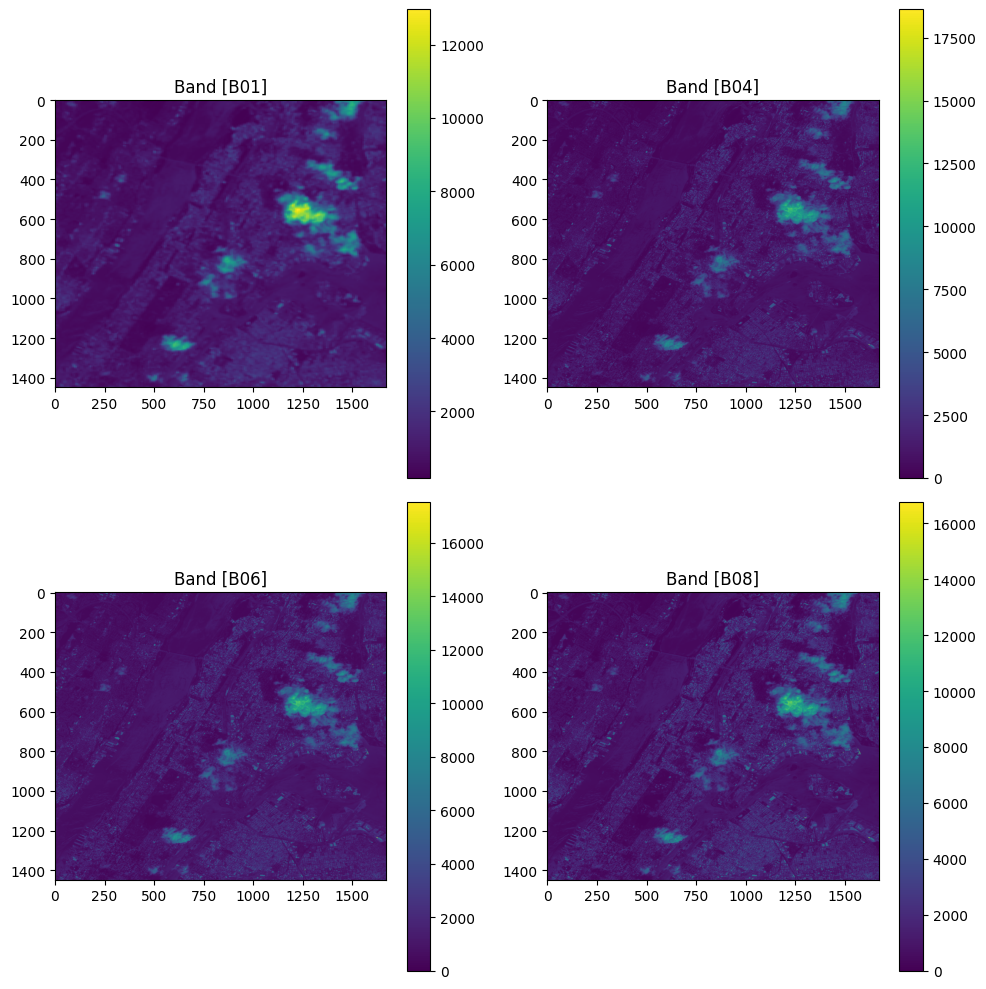

In [ ]:
# Open the GeoTIFF file
tiff_path = "../data/S2_sample.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B04]
    band3 = src1.read(3)  # Band [B06]
    band4 = src1.read(4)  # Band [B08]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B04)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B04]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B06)
im3 = axes[2].imshow(band3, cmap='viridis')                 
axes[2].set_title('Band [B06]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B08)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 3</strong></h4>

Instead of a single point data extraction, participants might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if the specified distance was 50 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.




### Extracting Band Values from the GeoTIFF Image


In [6]:
def map_satellite_data_with_buffer(tiff_path, csv_path, buffer_radius=700, 
                                  weighting='gaussian', land_cover_mask=None, 
                                  outlier_threshold=3, min_valid_pixels=5,
                                  adaptive_weighting=False, drop_invalid=True,
                                  handle_out_of_bounds='nearest'):
    """
    Extracts satellite band values from a GeoTIFF based on coordinates from a csv file,
    using advanced buffer techniques with customizable weighting schemes.
    
    Parameters:
    tiff_path (str): Path to the GeoTIFF file
    csv_path (str): Path to the CSV file containing coordinates
    buffer_radius (float): Radius in meters for the buffer zone (default: 700)
    weighting (str): Weighting method to use - options:
                    'uniform' - equal weight to all pixels (simple average)
                    'gaussian' - gaussian distance weighting (default)
                    'inverse' - inverse distance weighting
                    'triangular' - linear decrease with distance
    land_cover_mask (str): Optional path to land cover raster for masking (e.g., to exclude water pixels)
    outlier_threshold (float): Standard deviation threshold for outlier removal (default: 3)
    min_valid_pixels (int): Minimum number of valid pixels required (default: 5)
    adaptive_weighting (bool): If True, selects best weighting method for each point based on local variance (default: False)
    drop_invalid (bool): If True, drops points that are outside raster bounds or have NaN values (default: True)
    handle_out_of_bounds (str): How to handle points outside raster bounds:
                               'drop' - drop these points
                               'nearest' - use nearest valid pixel values
                               'knn' - use k-nearest neighbor interpolation from valid points
    
    Returns:
    pd.DataFrame: DataFrame containing processed band values for each input location with metadata
    """
    # Load the GeoTIFF data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = rxr.open_rasterio(tiff_path)
    
    # Load land cover mask if provided
    if land_cover_mask is not None:
        try:
            lc_data = rxr.open_rasterio(land_cover_mask)
        except Exception as e:
            print(f"Warning: Could not load land cover mask: {e}")
            land_cover_mask = None
    
    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)
    # Make sure latitude and longitude columns exist
    required_cols = ['Latitude', 'Longitude']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"CSV must contain {', '.join(required_cols)} columns")
    
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Calculate buffer size in pixels (assuming 10m resolution)
    buffer_pixels = int(np.ceil(buffer_radius / 10))
    
    # Identify band names from the raster data
    if hasattr(data, 'band_names') and data.band_names:
        band_names = data.band_names
    else:
        # Default Sentinel-2 band names
        band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 
                      'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
        if data.shape[0] != len(band_names):
            band_names = [f'Band_{i+1}' for i in range(data.shape[0])]
    
    # Initialize dictionary for band values and metadata
    result_dict = {band_name: [] for band_name in band_names}
    metadata = {
        'Latitude': [], 'Longitude': [], 
        'buffer_radius_m': [], 'pixels_used': [],
        'weighting': [], 'stddev': [], 'outliers_removed': []
    }

    # Get the affine transform from the data
    transform = data.rio.transform()
    resolution = data.rio.resolution()[0]  # Assuming square pixels
    
    # Define weighting function
    def get_weights(distances, method, radius):
        # Handle empty array
        if len(distances) == 0:
            return np.array([])
            
        if method == 'uniform':
            return np.ones_like(distances)
        elif method == 'gaussian':
            # Gaussian with sigma = radius/3 (so most weight is within radius)
            sigma = radius / 3
            return np.exp(-(distances**2) / (2 * sigma**2))
        elif method == 'inverse':
            # Add small epsilon to avoid division by zero
            return 1 / (distances + 0.1)
        elif method == 'triangular':
            # Linear decrease with distance
            return np.maximum(0, 1 - distances/radius)
        else:
            # Default to uniform if unknown method
            warnings.warn(f"Unknown weighting method: {method}, using uniform instead")
            return np.ones_like(distances)
    
    # Prepare for adaptive weighting
    weighting_methods = ['uniform', 'gaussian', 'inverse', 'triangular'] if adaptive_weighting else [weighting]
    
    # Collect all valid and invalid points for potential interpolation
    valid_points = []
    invalid_indices = []
    
    # Iterate over the latitudes and longitudes
    invalid_points = 0
    for idx, (lat, lon) in enumerate(tqdm(zip(latitudes, longitudes), 
                                         total=len(latitudes), 
                                         desc="Processing locations")):
        # Convert lat/lon to pixel coordinates
        col, row = ~transform * (lon, lat)
        row, col = int(row), int(col)
        
        # Check if point is within raster bounds
        if (row < 0 or row >= data.rio.width or 
            col < 0 or col >= data.rio.height):
            invalid_points += 1
            invalid_indices.append(idx)
            
            # For invalid points, we'll handle them based on the chosen method
            if handle_out_of_bounds == 'drop':
                # Fill with NaN (original behavior)
                for band_name in band_names:
                    result_dict[band_name].append(np.nan)
                # Add metadata
                metadata['Latitude'].append(lat)
                metadata['Longitude'].append(lon)
                metadata['buffer_radius_m'].append(buffer_radius)
                metadata['pixels_used'].append(np.nan)
                metadata['weighting'].append(weighting)
                metadata['stddev'].append(np.nan)
                metadata['outliers_removed'].append(np.nan)
                continue
            else:
                # For 'nearest' and 'knn' methods, add placeholders temporarily
                for band_name in band_names:
                    result_dict[band_name].append(None)  # Placeholder to maintain index
                # Add metadata
                metadata['Latitude'].append(lat)
                metadata['Longitude'].append(lon)
                metadata['buffer_radius_m'].append(buffer_radius)
                metadata['pixels_used'].append(0)
                metadata['weighting'].append(weighting)
                metadata['stddev'].append(np.nan)
                metadata['outliers_removed'].append(0)
                continue
        
        # Keep track of valid points for potential interpolation
        valid_points.append((idx, lat, lon, row, col))
        
        # Calculate window bounds with padding to handle edge cases
        row_start = max(0, row - buffer_pixels)
        row_end = min(data.rio.width, row + buffer_pixels + 1)
        col_start = max(0, col - buffer_pixels)
        col_end = min(data.rio.height, col + buffer_pixels + 1)
        
        # Create a grid of pixel coordinates for the window
        y_indices, x_indices = np.indices((col_end - col_start, row_end - row_start))
        y_coords = y_indices + col_start
        x_coords = x_indices + row_start
        
        # Calculate distances from center point (in meters)
        distances = np.sqrt((x_coords - row)**2 + (y_coords - col)**2) * resolution
        
        # Create mask for pixels within buffer radius
        distance_mask = distances <= buffer_radius
        
        # Apply land cover mask if provided
        if land_cover_mask is not None:
            try:
                lc_window = lc_data[0, col_start:col_end, row_start:row_end].values
                # Assuming water classes are 0 or 1 (modify as needed for your land cover data)
                water_mask = ~np.isin(lc_window, [0, 1])
                combined_mask = distance_mask & water_mask
            except Exception:
                combined_mask = distance_mask
        else:
            combined_mask = distance_mask
        
        # Implement adaptive weighting if requested
        if adaptive_weighting:            
            # Get a sample band to analyze local characteristics
            sample_band_idx = min(3, len(band_names) - 1)  # Use band ~4 if available (good middle ground)
            sample_window = data[sample_band_idx, col_start:col_end, row_start:row_end].values
            valid_pixels = sample_window[distance_mask & ~np.isnan(sample_window)]
            
            # Skip adaptive weighting if not enough valid pixels
            if len(valid_pixels) < min_valid_pixels * 2:
                # Fall back to specified weighting method
                weighting_methods = [weighting]
            else:
                # Calculate metrics to determine best weighting method
                window_mean = np.mean(valid_pixels)
                window_cv = np.std(valid_pixels) / (window_mean + 1e-10)  # Coefficient of variation
                
                edge_values = sample_window[((x_coords == row_start) | (x_coords == row_end - 1) | 
                                           (y_coords == col_start) | (y_coords == col_end - 1)) & 
                                          distance_mask & ~np.isnan(sample_window)]
                center_values = sample_window[((x_coords - row)**2 + (y_coords - col)**2 <= (buffer_pixels/3)**2) & 
                                            ~np.isnan(sample_window)]
                
                # Calculate center-to-edge gradient 
                edge_mean = np.mean(edge_values) if len(edge_values) > 0 else window_mean
                center_mean = np.mean(center_values) if len(center_values) > 0 else window_mean
                gradient = abs(center_mean - edge_mean) / (window_mean + 1e-10)
                
                # Select weighting method based on local characteristics
                if gradient > 0.3:  # Strong center-to-edge gradient
                    # Strong gradient suggests gaussian or inverse weighting
                    weighting_methods = ['gaussian', 'inverse']
                elif window_cv < 0.1:  # Low variation
                    # Low variation suggests uniform weighting
                    weighting_methods = ['uniform']
                elif window_cv > 0.3:  # High variation
                    # High variation suggests triangular or gaussian (balance)
                    weighting_methods = ['triangular', 'gaussian']
                # Otherwise test all methods
        
        # Process each band
        point_metadata = {
            'pixels_used': 0,
            'stddev': [],
            'outliers_removed': 0,
            'selected_weighting': weighting
        }
        
        # Store results for each weighting method if adaptive weighting is used
        if len(weighting_methods) > 1:
            weighting_results = {method: {} for method in weighting_methods}
        
        for band_idx, band_name in enumerate(band_names):
            # Get the band data for the window
            try:
                window_data = data[band_idx, col_start:col_end, row_start:row_end].values
            except IndexError:
                # Handle case where band index doesn't match data dimensions
                result_dict[band_name].append(np.nan)
                continue
                
            # Apply mask and get valid values
            valid_mask = combined_mask & ~np.isnan(window_data)
            valid_values = window_data[valid_mask]
            valid_weights = get_weights(distances[valid_mask], weighting_methods[0], buffer_radius)
            
            # Skip if no valid values
            if len(valid_values) < min_valid_pixels:
                if len(weighting_methods) > 1:
                    for method in weighting_methods:
                        if band_name not in weighting_results[method]:
                            weighting_results[method][band_name] = np.nan
                else:
                    result_dict[band_name].append(np.nan)
                continue
                
            # Store initial number of pixels
            initial_pixels = len(valid_values)
            
            # Remove outliers if requested and if we have enough data points
            if outlier_threshold is not None and len(valid_values) > 10:
                mean = np.mean(valid_values)
                std = np.std(valid_values)
                if std > 0:  # Only filter if there's actually variation
                    outlier_mask = np.abs(valid_values - mean) <= (outlier_threshold * std)
                    
                    # Update values and weights
                    valid_values = valid_values[outlier_mask]
                    valid_weights = valid_weights[outlier_mask]
                    outliers_removed = initial_pixels - len(valid_values)
                    point_metadata['outliers_removed'] = outliers_removed
            
            # Calculate weighted average
            if len(valid_values) > 0:
                # If testing multiple weighting methods
                if len(weighting_methods) > 1:
                    # Store results for each method
                    for method in weighting_methods:
                        method_weights = get_weights(distances[valid_mask], method, buffer_radius)
                        # Ensure weights and values have the same shape
                        if len(method_weights) != len(valid_values):
                            # Reshape weights to match values
                            if len(valid_values) < len(method_weights):
                                method_weights = method_weights[:len(valid_values)]
                            else:
                                # Pad weights if necessary (shouldn't happen in normal cases)
                                pad_length = len(valid_values) - len(method_weights)
                                method_weights = np.pad(method_weights, (0, pad_length), 'constant', constant_values=(0,))
                        
                        # Normalize weights (ensure they sum to 1)
                        if np.sum(method_weights) > 0:
                            method_weights = method_weights / np.sum(method_weights)
                        else:
                            method_weights = np.ones_like(valid_values) / len(valid_values)
                            
                        # Calculate weighted average
                        weighted_avg = np.sum(valid_values * method_weights)
                        std_dev = np.std(valid_values)
                        
                        # Store in temporary dictionary
                        if band_name not in weighting_results[method]:
                            weighting_results[method][band_name] = weighted_avg
                            weighting_results[method]['stddev'] = [std_dev]
                        else:
                            weighting_results[method]['stddev'].append(std_dev)
                else:
                    # Single weighting method (standard case)
                    # Normalize weights
                    valid_weights = valid_weights / np.sum(valid_weights)
                    weighted_avg = np.sum(valid_values * valid_weights)
                    std_dev = np.std(valid_values)
                    
                    result_dict[band_name].append(weighted_avg)
                    point_metadata['pixels_used'] = len(valid_values)
                    point_metadata['stddev'].append(std_dev)
            else:
                # Fallback to center pixel if no valid values in buffer
                try:
                    center_value = data[band_idx, col, row].values
                    center_value_float = float(center_value)
                    
                    if len(weighting_methods) > 1:
                        for method in weighting_methods:
                            if band_name not in weighting_results[method]:
                                weighting_results[method][band_name] = center_value_float
                    else:
                        result_dict[band_name].append(center_value_float)
                except:
                    if len(weighting_methods) > 1:
                        for method in weighting_methods:
                            if band_name not in weighting_results[method]:
                                weighting_results[method][band_name] = np.nan
                    else:
                        result_dict[band_name].append(np.nan)
        
        # If using adaptive weighting, select the best method
        if len(weighting_methods) > 1:
            # Criteria for selecting best weighting method:
            # 1. Lowest coefficient of variation of spectral indices (if we have enough bands)
            # 2. Balance between spatial smoothness and feature preservation
            
            method_scores = {}
            for method in weighting_methods:
                # Calculate mean and variance across bands
                band_values = [val for key, val in weighting_results[method].items() 
                              if key not in ['stddev'] and not np.isnan(val)]
                
                if len(band_values) >= 3:  # Need at least a few bands for a meaningful analysis
                    # Calculate coefficient of variation (lower is better for stability)
                    cv = np.std(band_values) / (np.mean(np.abs(band_values)) + 1e-10)
                    
                    # Calculate average standard deviation (lower is better for noise reduction)
                    avg_stddev = np.mean(weighting_results[method].get('stddev', [0]))
                    
                    # Score based on balance between CV and stddev
                    # We prefer methods that balance smoothness (low stddev) with feature preservation (not too low CV)
                    score = -cv * 0.4 - (avg_stddev / (np.mean(np.abs(band_values)) + 1e-10)) * 0.6
                    method_scores[method] = score
            
            # Select best method (highest score)
            if method_scores:
                best_method = max(method_scores.items(), key=lambda x: x[1])[0]
                point_metadata['selected_weighting'] = best_method
                
                # Add the values from best method to result
                for band_name in band_names:
                    if band_name in weighting_results[best_method]:
                        result_dict[band_name].append(weighting_results[best_method][band_name])
                
                # Update metadata
                if 'stddev' in weighting_results[best_method]:
                    point_metadata['stddev'] = np.mean(weighting_results[best_method]['stddev'])
                else:
                    point_metadata['stddev'] = np.nan
            else:
                # If no valid scores, use default weighting
                best_method = weighting
                point_metadata['selected_weighting'] = best_method
                
                # Add results using default method
                for band_name in band_names:
                    if band_name in weighting_results[best_method]:
                        result_dict[band_name].append(weighting_results[best_method][band_name])
        
        # Calculate average standard deviation across bands
        if point_metadata['stddev'] and not isinstance(point_metadata['stddev'], float):
            point_metadata['stddev'] = np.mean(point_metadata['stddev'])
            
        # Add metadata
        metadata['Latitude'].append(lat)
        metadata['Longitude'].append(lon)
        metadata['buffer_radius_m'].append(buffer_radius)
        metadata['pixels_used'].append(point_metadata['pixels_used'])
        metadata['weighting'].append(point_metadata['selected_weighting'])
        metadata['stddev'].append(point_metadata['stddev'])
        metadata['outliers_removed'].append(point_metadata['outliers_removed'])
    
    # Handle out-of-bounds points after processing valid ones
    if handle_out_of_bounds in ['nearest', 'knn'] and invalid_points > 0 and valid_points:
        print(f"Interpolating values for {invalid_points} out-of-bounds points...")
        
        # Need to import required libraries here for interpolation
        if handle_out_of_bounds == 'nearest':
            from scipy.spatial import cKDTree
        elif handle_out_of_bounds == 'knn':
            from sklearn.neighbors import KNeighborsRegressor
        
        # Extract valid lat/lon for interpolation
        valid_indices = [p[0] for p in valid_points]
        valid_lats = [p[1] for p in valid_points]
        valid_lons = [p[2] for p in valid_points]
        
        # For each band, interpolate values for invalid points
        for band_name in band_names:
            # Skip if this band wasn't processed for valid points
            if not all(isinstance(result_dict[band_name][i], (int, float)) for i in valid_indices):
                continue
                
            valid_values = [result_dict[band_name][i] for i in valid_indices 
                           if isinstance(result_dict[band_name][i], (int, float))]
            valid_coords = np.column_stack(([valid_lats[i] for i in range(len(valid_indices)) 
                                          if isinstance(result_dict[band_name][valid_indices[i]], (int, float))],
                                          [valid_lons[i] for i in range(len(valid_indices)) 
                                          if isinstance(result_dict[band_name][valid_indices[i]], (int, float))]))
            
            if len(valid_values) == 0 or len(valid_coords) == 0:
                continue
                
            if handle_out_of_bounds == 'nearest':
                # For each invalid point, find the nearest valid point
                # Build KD-tree with valid points
                tree = cKDTree(valid_coords)
                
                # For each invalid point
                for idx in invalid_indices:
                    invalid_lat = latitudes[idx]
                    invalid_lon = longitudes[idx]
                    
                    # Find nearest neighbor
                    dist, nn_idx = tree.query([invalid_lat, invalid_lon], k=1)
                    
                    # Use the value from nearest neighbor
                    result_dict[band_name][idx] = valid_values[nn_idx]
                    
                    # Update metadata to indicate this is an interpolated value
                    metadata['weighting'][idx] = f"nearest_interpolated_{weighting}"
                    metadata['pixels_used'][idx] = 1
            
            elif handle_out_of_bounds == 'knn':
                # K-nearest neighbors interpolation
                # Create and fit KNN model
                k = min(5, len(valid_coords))  # Use at most 5 neighbors
                knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
                knn.fit(valid_coords, valid_values)
                
                # Interpolate for invalid points
                invalid_coords = np.column_stack(([latitudes[i] for i in invalid_indices],
                                                 [longitudes[i] for i in invalid_indices]))
                
                interpolated_values = knn.predict(invalid_coords)
                
                # Assign interpolated values
                for i, idx in enumerate(invalid_indices):
                    result_dict[band_name][idx] = interpolated_values[i]
                    
                    # Update metadata to indicate this is an interpolated value
                    metadata['weighting'][idx] = f"knn{k}_interpolated_{weighting}"
                    metadata['pixels_used'][idx] = k

    if invalid_points > 0:
        if handle_out_of_bounds == 'drop':
            print(f"Warning: {invalid_points} points were outside the raster bounds.")
        else:
            print(f"Handled {invalid_points} out-of-bounds points using '{handle_out_of_bounds}' method.")
    
    # Create results DataFrame
    result_df = pd.DataFrame(result_dict)
    
    # Add metadata columns
    for key, values in metadata.items():
        result_df[key] = values
    
    # Add derived spectral indices relevant for urban heat island studies
    try:
        # Vegetation indices
        # NDVI - Normalized Difference Vegetation Index
        if 'B08' in result_df.columns and 'B04' in result_df.columns:
            result_df['NDVI'] = (result_df['B08'] - result_df['B04']) / (result_df['B08'] + result_df['B04'] + 1e-10)
        
        # EVI - Enhanced Vegetation Index (reduces atmospheric and soil background influences)
        if all(band in result_df.columns for band in ['B02', 'B04', 'B08']):
            result_df['EVI'] = 2.5 * ((result_df['B08'] - result_df['B04']) / 
                                    (result_df['B08'] + 6 * result_df['B04'] - 7.5 * result_df['B02'] + 1 + 1e-10))
        
        # SAVI - Soil Adjusted Vegetation Index (L=0.5 typically)
        if 'B08' in result_df.columns and 'B04' in result_df.columns:
            L = 0.5  # Soil brightness correction factor
            result_df['SAVI'] = ((result_df['B08'] - result_df['B04']) / 
                               (result_df['B08'] + result_df['B04'] + L + 1e-10)) * (1 + L)
        
        # MSAVI2 - Modified Soil Adjusted Vegetation Index
        if 'B08' in result_df.columns and 'B04' in result_df.columns:
            NIR = result_df['B08']
            RED = result_df['B04']
            result_df['MSAVI'] = (2 * NIR + 1 - np.sqrt((2 * NIR + 1)**2 - 8 * (NIR - RED))) / 2
        
        # Water indices
        # NDWI - Normalized Difference Water Index (Green-NIR)
        if 'B03' in result_df.columns and 'B08' in result_df.columns:
            result_df['NDWI'] = (result_df['B03'] - result_df['B08']) / (result_df['B03'] + result_df['B08'] + 1e-10)
        
        # MNDWI - Modified NDWI (Green-SWIR)
        if 'B03' in result_df.columns and 'B11' in result_df.columns:
            result_df['MNDWI'] = (result_df['B03'] - result_df['B11']) / (result_df['B03'] + result_df['B11'] + 1e-10)
        
        # WRI - Water Ratio Index
        if all(band in result_df.columns for band in ['B03', 'B04', 'B08', 'B11']):
            result_df['WRI'] = (result_df['B03'] + result_df['B04']) / (result_df['B08'] + result_df['B11'] + 1e-10)
        
        # Built-up/Urban indices
        # NDBI - Normalized Difference Built-up Index
        if 'B08' in result_df.columns and 'B11' in result_df.columns:
            result_df['NDBI'] = (result_df['B11'] - result_df['B08']) / (result_df['B11'] + result_df['B08'] + 1e-10)
        
        # BUI - Built-Up Index (combination of NDBI and NDVI)
        if 'NDBI' in result_df.columns and 'NDVI' in result_df.columns:
            result_df['BUI'] = result_df['NDBI'] - result_df['NDVI']
        
        # UI - Urban Index
        if 'B07' in result_df.columns and 'B04' in result_df.columns:
            result_df['UI'] = (result_df['B07'] - result_df['B04']) / (result_df['B07'] + result_df['B04'] + 1e-10)
        
        # NDBaI - Normalized Difference Bareness Index
        if 'B11' in result_df.columns and 'B12' in result_df.columns:
            result_df['NDBaI'] = (result_df['B11'] - result_df['B12']) / (result_df['B11'] + result_df['B12'] + 1e-10)
        
        # Thermal/Heat related indices
        # NBDI - Normalized Difference Bareness Index (different from NDBaI)
        if 'B11' in result_df.columns and 'B08' in result_df.columns:
            result_df['NBDI'] = (result_df['B11'] - result_df['B08']) / (result_df['B11'] + result_df['B08'] + 1e-10)
        
        # BSI - Bare Soil Index
        if all(band in result_df.columns for band in ['B02', 'B04', 'B08', 'B11']):
            result_df['BSI'] = ((result_df['B04'] + result_df['B11']) - (result_df['B08'] + result_df['B02'])) / \
                             ((result_df['B04'] + result_df['B11']) + (result_df['B08'] + result_df['B02']) + 1e-10)
        
        # IBI - Index-based Built-up Index
        if all(ind in result_df.columns for ind in ['NDBI', 'SAVI', 'MNDWI']):
            IBI_num = result_df['NDBI'] - (result_df['SAVI'] + result_df['MNDWI']) / 2
            IBI_denom = result_df['NDBI'] + (result_df['SAVI'] + result_df['MNDWI']) / 2
            result_df['IBI'] = IBI_num / (IBI_denom + 1e-10)
        
        # Additional composite indices useful for UHI studies
        # EBBI - Enhanced Built-Up and Bareness Index
        if all(band in result_df.columns for band in ['B08', 'B11', 'B12']):
            result_df['EBBI'] = (result_df['B11'] - result_df['B08']) / \
                              (10 * np.sqrt(result_df['B11'] + result_df['B12'] + 1e-10))
        
        # UTFVI - Urban Thermal Field Variance Index (if SWIR bands are available as proxy for temperature)
        if 'B11' in result_df.columns and 'NDVI' in result_df.columns:
            # Using SWIR as thermal proxy (not ideal but workable without thermal bands)
            result_df['UTFVI'] = (result_df['B11'] - result_df['NDVI']) / (result_df['B11'] + result_df['NDVI'] + 1e-10)
            
    except Exception as e:
        print(f"Warning: Could not calculate some indices: {e}")
        
    if drop_invalid:
        initial_rows = len(result_df)
        
        # Create a mask for rows where any band column contains NaN or null values
        band_columns = [col for col in result_df.columns if col in band_names]
        
        # Check for NaN, None, and other invalid values
        # This combines checks for np.nan, None, and other invalid values
        invalid_mask = result_df[band_columns].isna().any(axis=1)  # Catches np.nan
        
        # Also consider rows with very extreme values that might indicate errors
        # (optional - remove if not needed for your specific data)
        for col in band_columns:
            if col in result_df.columns:
                # Check for infinite values
                if result_df[col].dtype.kind in 'fc':  # float or complex columns
                    invalid_mask = invalid_mask | np.isinf(result_df[col])
        
        # Drop the rows that have invalid values
        result_df = result_df[~invalid_mask]
        
        # Report the number of dropped rows
        dropped_rows = initial_rows - len(result_df)
        if dropped_rows > 0:
            print(f"Dropped {dropped_rows} rows with missing/invalid values.")
    
    return result_df

In [8]:
final_data = map_satellite_data_with_buffer(
    '../data/S2_sample.tiff',
    '../data/Training_data_uhi_index_2025-02-18.csv',
    buffer_radius=700,
    adaptive_weighting=True,
    outlier_threshold=2.5,
    drop_invalid=False,
    handle_out_of_bounds='knn'
)

Processing locations: 100%|██████████| 11229/11229 [03:31<00:00, 53.20it/s]


Interpolating values for 36 out-of-bounds points...
Handled 36 out-of-bounds points using 'knn' method.


In [9]:
final_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,...,WRI,NDBI,BUI,UI,NDBaI,NBDI,BSI,IBI,EBBI,UTFVI
0,1033.013326,996.991705,1122.245863,1119.697232,1258.382628,1409.243826,1489.814501,1427.063128,1524.802546,1420.836359,...,0.787227,-0.002186,-0.122875,0.141834,0.081203,-0.002186,0.023462,-1.147702,-0.012146,0.999830
1,1033.013326,996.991705,1122.245863,1119.697232,1258.382628,1409.243826,1489.814501,1427.063128,1524.802546,1420.836359,...,0.787227,-0.002186,-0.122875,0.141834,0.081203,-0.002186,0.023462,-1.147702,-0.012146,0.999830
2,1032.333178,996.945546,1122.658324,1119.596433,1257.195607,1408.091454,1488.250554,1425.043147,1524.113094,1418.064950,...,0.788663,-0.002454,-0.122490,0.141363,0.082054,-0.002454,0.023323,-1.166854,-0.013630,0.999831
3,1031.530172,995.986547,1122.221817,1118.352445,1254.763776,1404.536866,1483.899446,1419.912940,1519.277383,1412.438729,...,0.791065,-0.002639,-0.121445,0.140473,0.082140,-0.002639,0.023226,-1.180756,-0.014629,0.999832
4,1030.105159,995.280723,1121.580141,1116.910548,1251.920832,1401.007813,1479.304316,1415.865157,1514.787527,1405.096783,...,0.793520,-0.003817,-0.121852,0.139585,0.082553,-0.003817,0.022473,-1.267069,-0.021135,0.999832


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [11]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [12]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,...,WRI,NDBI,BUI,UI,NDBaI,NBDI,BSI,IBI,EBBI,UTFVI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,1033.013326,996.991705,1122.245863,1119.697232,1258.382628,1409.243826,...,0.787227,-0.002186,-0.122875,0.141834,0.081203,-0.002186,0.023462,-1.147702,-0.012146,0.999830
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,1033.013326,996.991705,1122.245863,1119.697232,1258.382628,1409.243826,...,0.787227,-0.002186,-0.122875,0.141834,0.081203,-0.002186,0.023462,-1.147702,-0.012146,0.999830
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,1032.333178,996.945546,1122.658324,1119.596433,1257.195607,1408.091454,...,0.788663,-0.002454,-0.122490,0.141363,0.082054,-0.002454,0.023323,-1.166854,-0.013630,0.999831
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,1031.530172,995.986547,1122.221817,1118.352445,1254.763776,1404.536866,...,0.791065,-0.002639,-0.121445,0.140473,0.082140,-0.002639,0.023226,-1.180756,-0.014629,0.999832
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,1030.105159,995.280723,1121.580141,1116.910548,1251.920832,1401.007813,...,0.793520,-0.003817,-0.121852,0.139585,0.082553,-0.003817,0.022473,-1.267069,-0.021135,0.999832


## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [13]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01', 'B02', 'B03',
       'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'Latitude',
       'Longitude', 'buffer_radius_m', 'pixels_used', 'weighting', 'stddev',
       'outliers_removed', 'NDVI', 'EVI', 'SAVI', 'MSAVI', 'NDWI', 'MNDWI',
       'WRI', 'NDBI', 'BUI', 'UI', 'NDBaI', 'NBDI', 'BSI', 'IBI', 'EBBI',
       'UTFVI']

for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()


,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,...,WRI,NDBI,BUI,UI,NDBaI,NBDI,BSI,IBI,EBBI,UTFVI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,1033.013326,996.991705,1122.245863,1119.697232,1258.382628,1409.243826,...,0.787227,-0.002186,-0.122875,0.141834,0.081203,-0.002186,0.023462,-1.147702,-0.012146,0.999830
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,1033.013326,996.991705,1122.245863,1119.697232,1258.382628,1409.243826,...,0.787227,-0.002186,-0.122875,0.141834,0.081203,-0.002186,0.023462,-1.147702,-0.012146,0.999830
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,1032.333178,996.945546,1122.658324,1119.596433,1257.195607,1408.091454,...,0.788663,-0.002454,-0.122490,0.141363,0.082054,-0.002454,0.023323,-1.166854,-0.013630,0.999831
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,1031.530172,995.986547,1122.221817,1118.352445,1254.763776,1404.536866,...,0.791065,-0.002639,-0.121445,0.140473,0.082140,-0.002639,0.023226,-1.180756,-0.014629,0.999832
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,1030.105159,995.280723,1121.580141,1116.910548,1251.920832,1401.007813,...,0.793520,-0.003817,-0.121852,0.139585,0.082553,-0.003817,0.022473,-1.267069,-0.021135,0.999832


In [14]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

## Feature Engineering

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [ ]:
uhi_data = uhi_data[['B01', 'B02', 'B03',
       'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'NDVI', 
       'EVI', 'SAVI', 'MSAVI', 'NDWI', 'MNDWI',
       'WRI', 'NDBI', 'BUI', 'UI', 'NDBaI', 'NBDI', 'BSI', 'IBI', 'EBBI',
       'UTFVI','UHI Index']]

In [17]:
# Basic dataset info
print("Feature names:", uhi_data.drop(columns=['UHI Index']).columns.tolist())
print("\nShape of data:", X.shape)

Feature names: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'NDVI', 'EVI', 'SAVI', 'MSAVI', 'NDWI', 'MNDWI', 'WRI', 'NDBI', 'BUI', 'UI', 'NDBaI', 'NBDI', 'BSI', 'IBI', 'EBBI', 'UTFVI']

Shape of data: (11229, 27)


In [20]:
# Drop missing values
uhi_data = uhi_data.dropna()
print("\nShape after dropping missing values:", uhi_data.shape)

# Alternatively, you can fill missing values with the mean or median
# For numerical columns
# uhi_data_filled = uhi_data.fillna(uhi_data.mean(numeric_only=True))

# Or you can fill specific columns
# uhi_data['column_name'].fillna(uhi_data['column_name'].median(), inplace=True)


Shape after dropping missing values: (11229, 28)


In [21]:
# Basic statistics of features
print("\nFeature statistics:\n", uhi_data.describe())


Feature statistics:
                 B01           B02           B03           B04           B05  \
count  11229.000000  11229.000000  11229.000000  11229.000000  11229.000000   
mean    1358.856989   1336.060492   1442.959689   1463.044640   1679.157475   
std      993.654688    955.044156    896.351170    898.441361    937.725135   
min      489.279948    446.497809    499.736058    395.043876    541.929419   
25%      960.604486    937.471447   1064.884698   1076.074625   1276.196875   
50%     1117.730075   1107.999017   1254.200786   1302.945706   1511.239854   
75%     1266.814776   1270.884510   1399.676606   1463.261976   1688.032011   
max     7392.180685   7154.234646   6897.089142   6858.619056   7367.439704   

                B06           B07           B08           B8A           B11  \
count  11229.000000  11229.000000  11229.000000  11229.000000  11229.000000   
mean    2029.454118   2162.534208   2156.450755   2219.916032   1952.225652   
std      832.425262    793.76

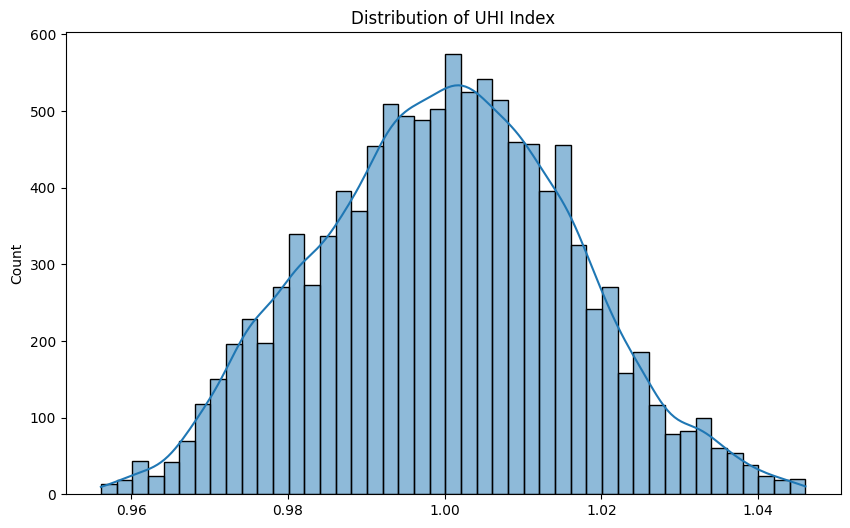

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Distribution of UHI Index')
plt.show()

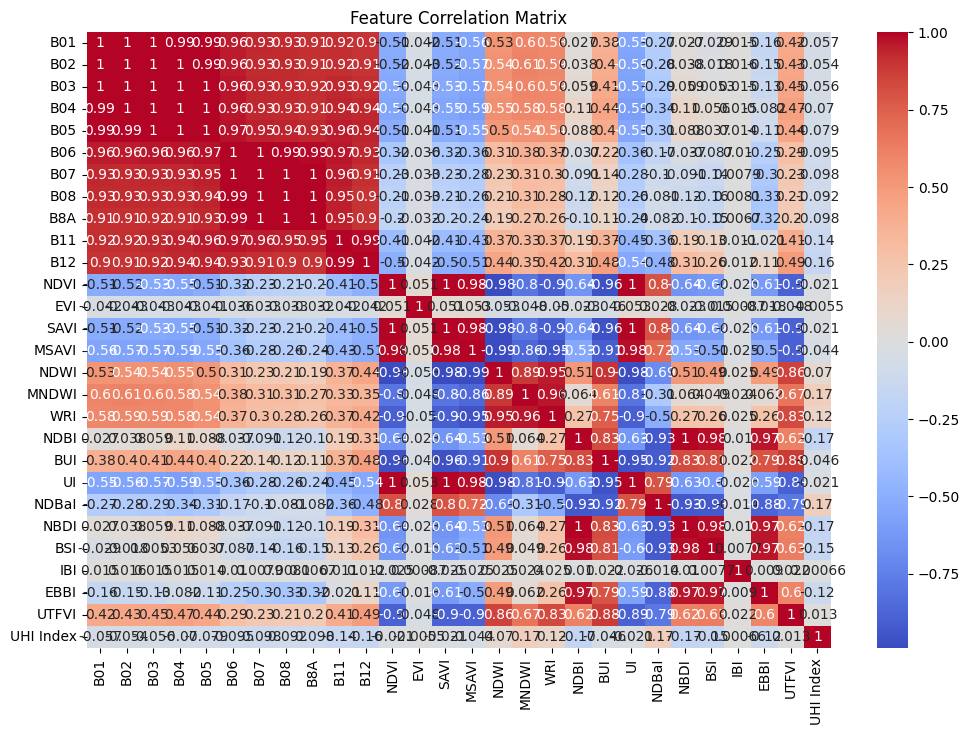

In [23]:
# Feature correlations
correlation_matrix = uhi_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### Feature Selection 

In [98]:
selected_data = uhi_data[['B01',
       'B04', 'B06', 'B8A', 'B12', 'NDVI', 
       'EVI', 'SAVI', 'MSAVI', 'NDWI', 'MNDWI',
       'WRI', 'NDBI', 'BUI', 'UI', 'NDBaI', 'NBDI', 'BSI', 'IBI', 'EBBI',
       'UTFVI','UHI Index']]

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 4</strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Participants should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [99]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = selected_data.drop(columns=['UHI Index']).values
y = selected_data['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123)

In [100]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables (Band B01, B06, NDVI) in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>


In [101]:
# Train the Random Forest model on the training data
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

## Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the R² score, a common metric for regression models that measures how well the model explains the variance in the response variable (UHI index). Scikit-learn provides many other metrics that can be used for evaluation, and you can also write custom code for more specific evaluation needs.</p>


### In-Sample Evaluation
<p align="justify">We will be evaluating our model's performance using the R² score on the training data. It is important to note that this is in-sample performance testing, which involves evaluating the model on the training dataset. These metrics are not truly indicative of the model's ability to generalize. You should reserve testing on the test data before drawing final conclusions about your model's performance.</p>


<p align="justify">In this section, we make predictions on the training set and store them in the <b><i>insample_predictions</i></b> variable. The R² score is then calculated to gauge the model's performance on the training data. It is important to keep in mind that this evaluation is for the training set, and further testing on the test set is necessary to assess the model's generalizability.</p>


In [102]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [103]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9905182192218626

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [104]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

In [105]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.9399259970468918

## Random Forest Optimization

In [106]:
feature_names = selected_data.drop(columns=['UHI Index']).columns

X_train_scaled = X_train
X_test_scaled = X_test

# Create interaction features
print("\nCreating interaction features...")
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Get feature names for polynomial features
def get_poly_feature_names(feature_names, poly):
    if hasattr(poly, 'get_feature_names_out'):
        return poly.get_feature_names_out(feature_names)
    else:  # For older sklearn versions
        return poly.get_feature_names(feature_names)

poly_feature_names = get_poly_feature_names(feature_names, poly)
print(f"Total features after interactions: {len(poly_feature_names)}")

# Function to evaluate and store model results
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_mae = mean_absolute_error(y_test, test_preds)
    
    print(f"{model_name} - Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.6f}, Test MAE: {test_mae:.6f}")
    
    return {
        'model': model,
        'train_preds': train_preds,
        'test_preds': test_preds,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae
    }

# 1. Define additional models to try
print("\n1. Evaluating a diverse set of models...")

# List of models to try
models_to_try = {
    # Best model from previous analysis 
    "RF with Interactions": RandomForestRegressor(
        n_estimators=434, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        max_features=0.5, 
        max_depth=None, 
        bootstrap=False, 
        random_state=42
    ),
    
    # Additional tree-based models
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "ExtraTrees": ExtraTreesRegressor(random_state=42),
    
    # Linear models
    "ElasticNet": ElasticNet(random_state=42),
    "Ridge": Ridge(random_state=42),
    
    # Support Vector Regression
    "SVR": SVR(),
    
    # K-Nearest Neighbors
    "KNN": KNeighborsRegressor(),
    
    # Advanced boosting models
    "XGBoost": XGBRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0)
}

# Container for model results
model_results = {}

# Evaluate each model with default parameters
for model_name, model in models_to_try.items():
    try:
        if model_name == "RF with Interactions":
            model_results[model_name] = evaluate_model(model, X_train_poly, X_test_poly, y_train, y_test, model_name)
        else:
            model_results[model_name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, model_name)
    except Exception as e:
        print(f"Error with {model_name}: {e}")

# Find the best performing models for further optimization
top_models = sorted(model_results.items(), key=lambda x: x[1]['test_r2'], reverse=True)[:3]
print("\nTop 3 models for further optimization:")
for model_name, results in top_models:
    print(f"{model_name} - Test R²: {results['test_r2']:.4f}, RMSE: {results['test_rmse']:.6f}")


Creating interaction features...
Total features after interactions: 231

1. Evaluating a diverse set of models...
RF with Interactions - Train R²: 0.9979, Test R²: 0.9484, Test RMSE: 0.003665, Test MAE: 0.002345
GradientBoosting - Train R²: 0.6044, Test R²: 0.5697, Test RMSE: 0.010580, Test MAE: 0.008328
ExtraTrees - Train R²: 0.9979, Test R²: 0.9577, Test RMSE: 0.003318, Test MAE: 0.002181
ElasticNet - Train R²: 0.0000, Test R²: -0.0008, Test RMSE: 0.016137, Test MAE: 0.012998
Ridge - Train R²: 0.2122, Test R²: 0.2163, Test RMSE: 0.014280, Test MAE: 0.011491
SVR - Train R²: -0.0033, Test R²: -0.0076, Test RMSE: 0.016191, Test MAE: 0.013026
KNN - Train R²: 0.9531, Test R²: 0.9118, Test RMSE: 0.004790, Test MAE: 0.003139
XGBoost - Train R²: 0.9745, Test R²: 0.9182, Test RMSE: 0.004613, Test MAE: 0.003347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota


Creating interaction features...
Total features after interactions: 231

1. Evaluating baseline ExtraTrees model...
ExtraTrees Baseline - Train R²: 0.9979, Test R²: 0.9577, Test RMSE: 0.003318, Test MAE: 0.002181

2. Evaluating ExtraTrees with interaction features...
ExtraTrees with Interactions - Train R²: 0.9979, Test R²: 0.9588, Test RMSE: 0.003273, Test MAE: 0.002165

3. Performing grid search optimization...

Using interaction features for grid search as it performed better

Phase 1: Initial parameter screening...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters from initial screening: {'bootstrap': False, 'max_depth': None, 'max_features': 0.5, 'n_estimators': 400}
Best CV score from initial screening: 0.9496

Phase 2: Detailed parameter optimization...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters from detailed optimization: {'bootstrap': False, 'max_depth': 30, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_s

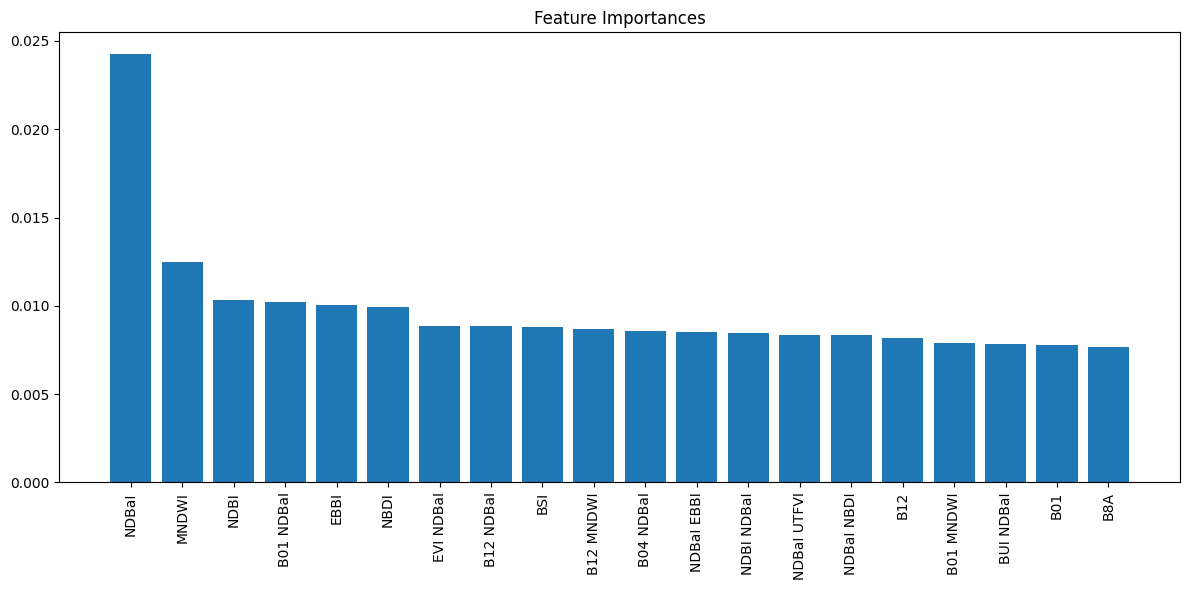

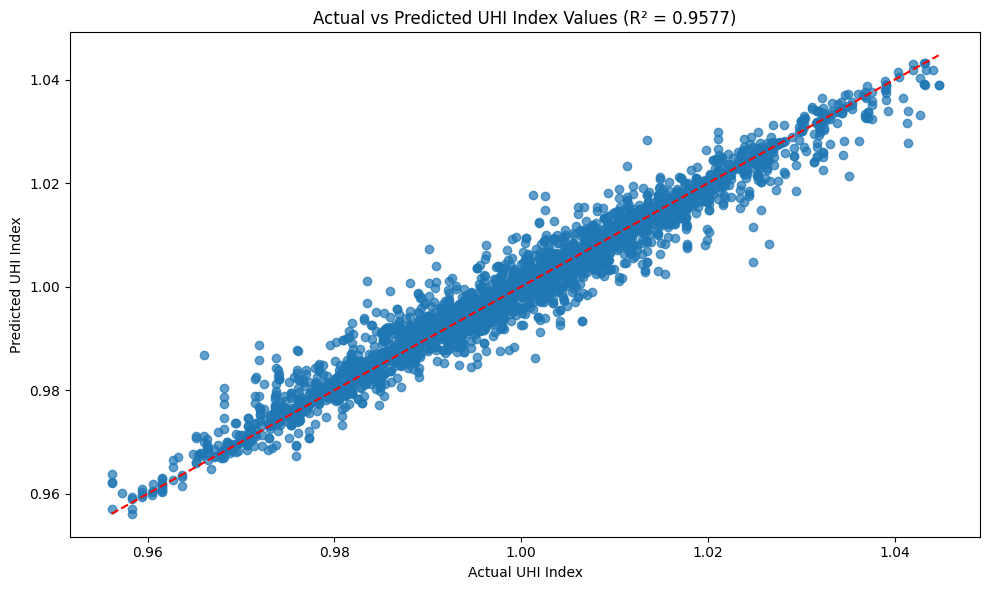

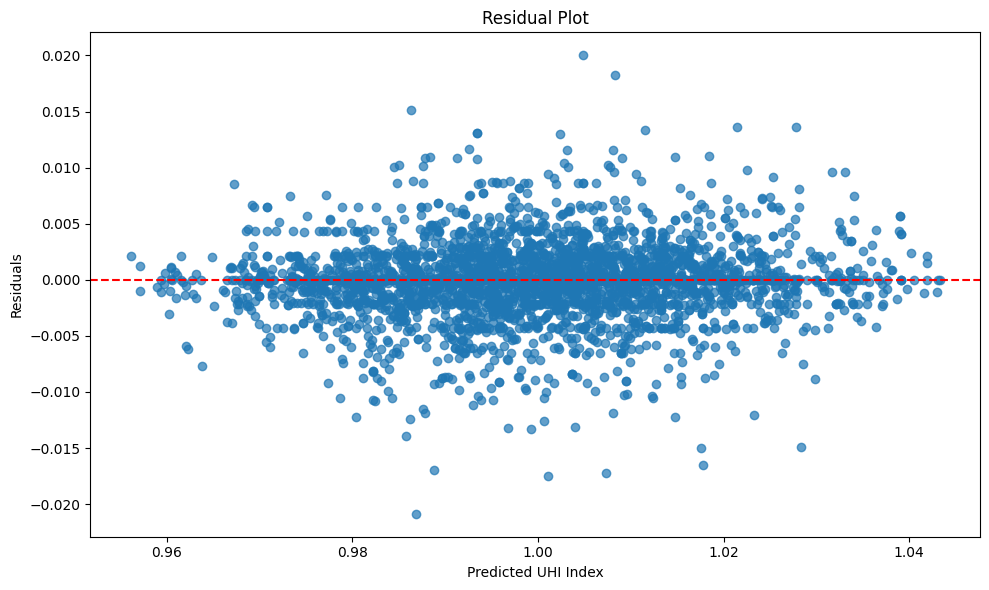

In [107]:
# Create directories if they don't exist
if not os.path.exists('models'):
    os.makedirs('models')
if not os.path.exists('results'):
    os.makedirs('results')

# Create interaction features
print("\nCreating interaction features...")
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Get feature names for polynomial features
def get_poly_feature_names(feature_names, poly):
    if hasattr(poly, 'get_feature_names_out'):
        return poly.get_feature_names_out(feature_names)
    else:  # For older sklearn versions
        return poly.get_feature_names(feature_names)

poly_feature_names = get_poly_feature_names(feature_names, poly)
print(f"Total features after interactions: {len(poly_feature_names)}")

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_mae = mean_absolute_error(y_test, test_preds)
    
    print(f"{model_name} - Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.6f}, Test MAE: {test_mae:.6f}")
    
    return {
        'model': model,
        'train_preds': train_preds,
        'test_preds': test_preds,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae
    }

# Initial baseline model evaluation
print("\n1. Evaluating baseline ExtraTrees model...")
base_model = ExtraTreesRegressor(random_state=42)
base_results = evaluate_model(base_model, X_train_scaled, X_test_scaled, y_train, y_test, "ExtraTrees Baseline")

# Try with polynomial features
print("\n2. Evaluating ExtraTrees with interaction features...")
base_poly_model = ExtraTreesRegressor(random_state=42)
base_poly_results = evaluate_model(base_poly_model, X_train_poly, X_test_poly, y_train, y_test, "ExtraTrees with Interactions")

# Define a more comprehensive grid search
print("\n3. Performing grid search optimization...")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 400, 600],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
    'bootstrap': [True, False]
}

# Determine which features to use based on best results so far
use_poly = base_poly_results['test_r2'] > base_results['test_r2']
X_train_best = X_train_poly if use_poly else X_train_scaled
X_test_best = X_test_poly if use_poly else X_test_scaled
feature_type = "interaction features" if use_poly else "standard features"
print(f"\nUsing {feature_type} for grid search as it performed better")

# First, do a preliminary search on a subset of parameters to narrow down the search space
print("\nPhase 1: Initial parameter screening...")
initial_param_grid = {
    'n_estimators': [100, 400],
    'max_depth': [None, 20],
    'max_features': ['sqrt', 0.5],
    'bootstrap': [True, False]
}

# Use cross-validation to robustly evaluate
cv = KFold(n_splits=5, shuffle=True, random_state=42)

initial_grid = GridSearchCV(
    ExtraTreesRegressor(random_state=42),
    param_grid=initial_param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

initial_grid.fit(X_train_best, y_train)
print(f"Best parameters from initial screening: {initial_grid.best_params_}")
print(f"Best CV score from initial screening: {initial_grid.best_score_:.4f}")

# Use the best params as a basis for a more focused search
best_params = initial_grid.best_params_

# Construct a more targeted grid
print("\nPhase 2: Detailed parameter optimization...")
if best_params['n_estimators'] == 100:
    n_estimators_range = [100, 200]
else:
    n_estimators_range = [400, 600]

if best_params['max_depth'] is None:
    max_depth_range = [None, 30]
else:
    base_depth = best_params['max_depth']
    max_depth_range = [base_depth, base_depth + 10]

if best_params['max_features'] == 'sqrt':
    max_features_range = ['sqrt', 0.5]
else:
    base_features = best_params['max_features'] if isinstance(best_params['max_features'], float) else 0.5
    max_features_range = [base_features, base_features + 0.1]

detailed_param_grid = {
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1],
    'max_features': max_features_range,
    'bootstrap': [best_params['bootstrap']]
}

# Detailed grid search
detailed_grid = GridSearchCV(
    ExtraTreesRegressor(random_state=42),
    param_grid=detailed_param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

detailed_grid.fit(X_train_best, y_train)
print(f"Best parameters from detailed optimization: {detailed_grid.best_params_}")
print(f"Best CV score from detailed optimization: {detailed_grid.best_score_:.4f}")

# Train the final model with best parameters
print("\n4. Evaluating final optimized ExtraTrees model...")
best_model = ExtraTreesRegressor(random_state=42, **detailed_grid.best_params_)
best_results = evaluate_model(
    best_model, 
    X_train_best, X_test_best, 
    y_train, y_test, 
    "ExtraTrees Optimized"
)

# Analyze feature importance
print("\n5. Analyzing feature importance...")
if use_poly:
    feature_names_used = poly_feature_names
else:
    feature_names_used = feature_names

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nFeature importance ranking:")
for f in range(min(20, len(importances))):
    if f < len(indices) and indices[f] < len(feature_names_used):
        print(f"{f+1}. {feature_names_used[indices[f]]} ({importances[indices[f]]:.4f})")

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(min(20, len(importances))), 
        [importances[i] for i in indices[:20] if i < len(importances)], 
        align="center")
plt.xticks(range(min(20, len(importances))), 
           [feature_names_used[i] for i in indices[:20] if i < len(feature_names_used)], 
           rotation=90)
plt.tight_layout()
plt.savefig('results/extratrees_feature_importances.png')

# Create predictions visualization
print("\n6. Creating visualization of predictions vs actuals...")
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_results['test_preds'], alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual UHI Index')
plt.ylabel('Predicted UHI Index')
plt.title(f'Actual vs Predicted UHI Index Values (R² = {best_results["test_r2"]:.4f})')
plt.tight_layout()
plt.savefig('results/extratrees_predictions.png')

# Calculate and display residuals
residuals = y_test - best_results['test_preds']
plt.figure(figsize=(10, 6))
plt.scatter(best_results['test_preds'], residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted UHI Index')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.savefig('results/extratrees_residual_plot.png')

# Save the model
print("\n7. Saving the final model...")
joblib.dump(best_model, 'models/final_model.pkl')
joblib.dump(sc, 'models/scaler.pkl')
if use_poly:
    joblib.dump(poly, 'models/poly_features.pkl')
    print("Saved with polynomial features transformer")

print("\nExtraTrees optimization completed successfully!")
print(f"Final model achieved Test R²: {best_results['test_r2']:.4f}, Test RMSE: {best_results['test_rmse']:.6f}")
print("The optimized model has been saved as 'models/final_model.pkl'")

# Compare to original best model
print("\nComparison to previous best model:")
previous_r2 = 0.9352  # From the RF with Interactions
improvement = best_results['test_r2'] - previous_r2
percent_improvement = (improvement / previous_r2) * 100
print(f"Previous best R²: {previous_r2:.4f}")
print(f"New best R²: {best_results['test_r2']:.4f}")
print(f"Improvement: {improvement:.4f} ({percent_improvement:.2f}%)")

## Model Evaluation

Training Set - R²: 0.9979, RMSE: 0.0007
Test Set - R²: 0.9577, RMSE: 0.0033
Overfitting Gap (Train R² - Test R²): 0.0402


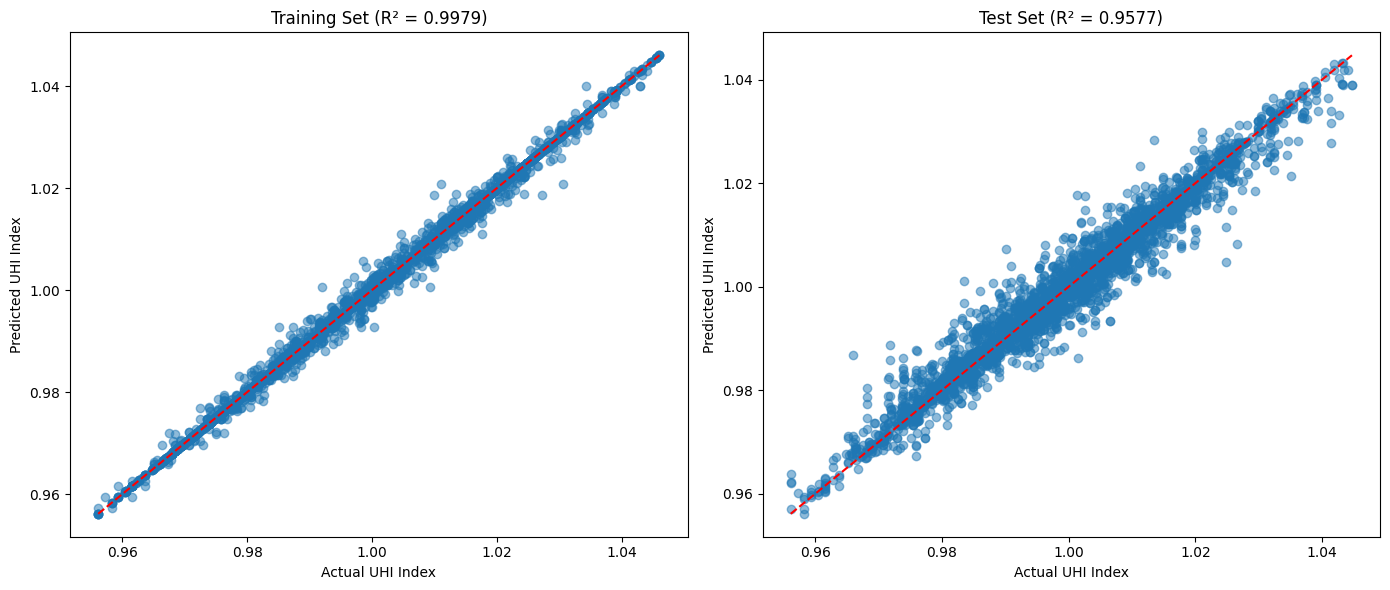

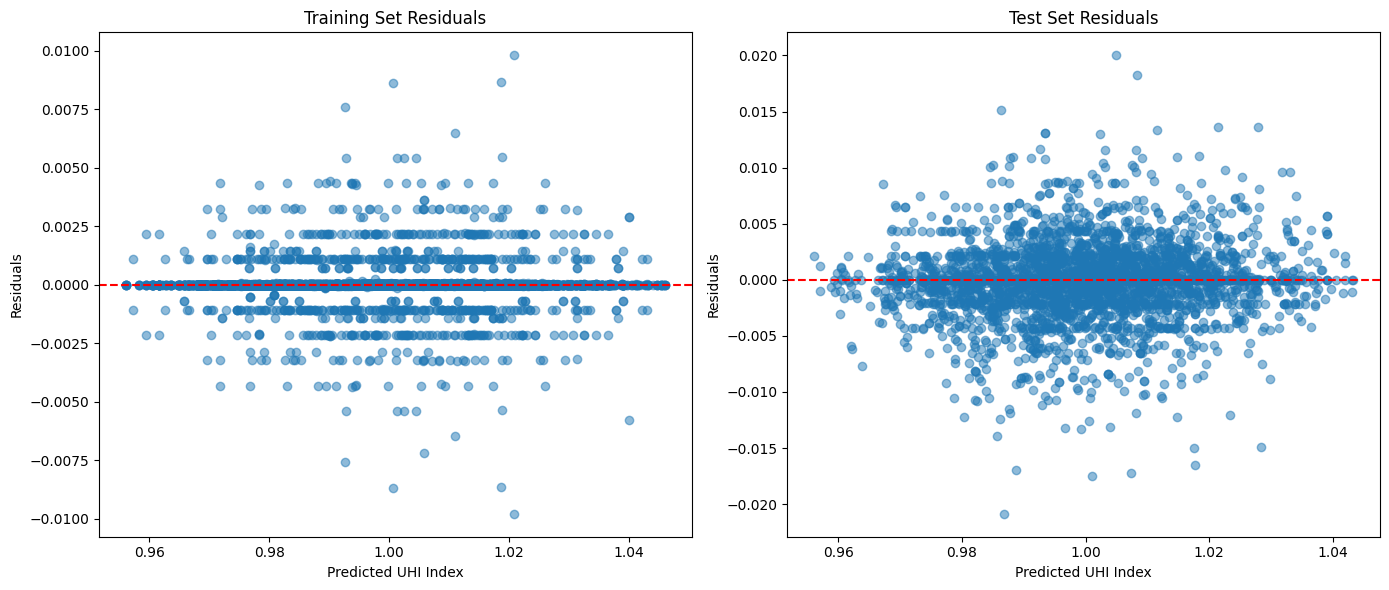

In [108]:
# 1. Load the saved models and transformers
model = joblib.load('models/final_model.pkl')  # Random Forest with Interactions
scaler = joblib.load('models/scaler.pkl')
poly = joblib.load('models/poly_features.pkl')

# 2. Load your training and test data
# Replace with your actual data loading code if different
# X_train, X_test, y_train, y_test should be loaded or already in memory from split

# 3. Apply preprocessing to both sets
X_train_scaled = X_train
X_test_scaled = X_test

X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# 4. Make predictions on both sets
train_predictions = model.predict(X_train_poly)
test_predictions = model.predict(X_test_poly)

# 5. Evaluate metrics for both sets
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"Training Set - R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
print(f"Test Set - R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}")
print(f"Overfitting Gap (Train R² - Test R²): {train_r2 - test_r2:.4f}")

# 6. Optional: Visualize predictions vs actuals for both sets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training set plot
ax1.scatter(y_train, train_predictions, alpha=0.5)
ax1.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
ax1.set_xlabel('Actual UHI Index')
ax1.set_ylabel('Predicted UHI Index')
ax1.set_title(f'Training Set (R² = {train_r2:.4f})')

# Test set plot
ax2.scatter(y_test, test_predictions, alpha=0.5)
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
ax2.set_xlabel('Actual UHI Index')
ax2.set_ylabel('Predicted UHI Index')
ax2.set_title(f'Test Set (R² = {test_r2:.4f})')

plt.tight_layout()
plt.savefig('results/train_test_predictions.png')
plt.show()

# 7. Optional: Create a residual plot for both sets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training residuals
train_residuals = y_train - train_predictions
ax1.scatter(train_predictions, train_residuals, alpha=0.5)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Predicted UHI Index')
ax1.set_ylabel('Residuals')
ax1.set_title('Training Set Residuals')

# Test residuals
test_residuals = y_test - test_predictions
ax2.scatter(test_predictions, test_residuals, alpha=0.5)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Predicted UHI Index')
ax2.set_ylabel('Residuals')
ax2.set_title('Test Set Residuals')

plt.tight_layout()
plt.savefig('results/train_test_residuals.png')
plt.show()

## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [109]:
#Reading the coordinates for the submission
test_file = pd.read_csv('../Submission_template_UHI2025-v2.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [110]:
val_data = map_satellite_data_with_buffer(
    '../data/S2_sample.tiff',
    '../Submission_template_UHI2025-v2.csv',
    buffer_radius=700,
    adaptive_weighting=True,
    outlier_threshold=2.5,
    drop_invalid=False,
    handle_out_of_bounds='knn'
)

Processing locations:   0%|          | 0/1040 [00:00<?, ?it/s]

Processing locations: 100%|██████████| 1040/1040 [00:16<00:00, 64.72it/s]

Interpolating values for 4 out-of-bounds points...
Handled 4 out-of-bounds points using 'knn' method.


In [111]:
val_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,...,WRI,NDBI,BUI,UI,NDBaI,NBDI,BSI,IBI,EBBI,UTFVI
0,1053.423835,1008.410398,1104.449063,1157.687108,1336.783721,1588.303973,1679.231904,1625.081236,1707.300097,1677.758767,...,0.684906,0.015949,-0.152011,0.183842,0.072111,0.015949,0.036928,-0.179257,0.094160,0.999800
1,1063.451762,1024.462035,1122.972216,1176.999170,1358.336584,1616.809178,1710.918999,1655.622250,1741.048184,1706.577031,...,0.684068,0.015155,-0.153813,0.184881,0.071480,0.015155,0.036575,-0.217437,0.090282,0.999802
2,1080.584946,1028.097364,1125.609092,1171.399511,1355.049757,1601.156491,1699.851469,1646.231160,1724.387118,1717.096807,...,0.682957,0.021070,-0.147452,0.184049,0.064501,0.021070,0.038500,-0.029091,0.124766,0.999804
3,1076.959378,1037.095622,1139.583906,1193.225832,1386.393560,1657.901088,1756.406951,1703.885010,1791.680561,1743.692091,...,0.676652,0.011546,-0.164719,0.190933,0.074408,0.011546,0.034509,-0.407293,0.069871,0.999798
4,998.594992,945.369375,1024.825527,1056.221933,1214.946058,1434.585670,1507.058742,1456.138372,1525.637918,1506.927488,...,0.702329,0.017141,-0.142039,0.175883,0.066104,0.017141,0.032558,-0.169751,0.095523,0.999789


In [112]:
# Extracting specific columns (B01, B06, and NDVI) from the validation dataset
submission_val_data=val_data.loc[:,['B01',
       'B04', 'B06', 'B8A', 'B12', 'NDVI', 
       'EVI', 'SAVI', 'MSAVI', 'NDWI', 'MNDWI',
       'WRI', 'NDBI', 'BUI', 'UI', 'NDBaI', 'NBDI', 'BSI', 'IBI', 'EBBI',
       'UTFVI']]
submission_val_data.head()

,B01,B04,B06,B8A,B12,NDVI,EVI,SAVI,MSAVI,NDWI,...,WRI,NDBI,BUI,UI,NDBaI,NBDI,BSI,IBI,EBBI,UTFVI
0,1053.423835,1157.687108,1588.303973,1707.300097,1452.062958,0.167960,1.157918,0.251895,0.287550,-0.190741,...,0.684906,0.015949,-0.152011,0.183842,0.072111,0.015949,0.036928,-0.179257,0.094160,0.999800
1,1063.451762,1176.999170,1616.809178,1741.048184,1478.880616,0.168968,1.155925,0.253408,0.289027,-0.191698,...,0.684068,0.015155,-0.153813,0.184881,0.071480,0.015155,0.036575,-0.217437,0.090282,0.999802
2,1080.584946,1171.399511,1601.156491,1724.387118,1509.009311,0.168522,1.230264,0.252738,0.288373,-0.187825,...,0.682957,0.021070,-0.147452,0.184049,0.064501,0.021070,0.038500,-0.029091,0.124766,0.999804
3,1076.959378,1193.225832,1657.901088,1791.680561,1502.173539,0.176265,1.175526,0.264352,0.299641,-0.198455,...,0.676652,0.011546,-0.164719,0.190933,0.074408,0.011546,0.034509,-0.407293,0.069871,0.999798
4,998.594992,1056.221933,1434.585670,1525.637918,1320.052401,0.159180,1.419755,0.238722,0.274573,-0.173849,...,0.702329,0.017141,-0.142039,0.175883,0.066104,0.017141,0.032558,-0.169751,0.095523,0.999789


In [113]:
scaler = joblib.load('models/scaler.pkl')
poly = joblib.load('models/poly_features.pkl')
model = joblib.load('models/final_model.pkl')

# Impute NaN values with median of each column
for column in submission_val_data.columns:
    median_value = submission_val_data[column].median()
    submission_val_data[column].fillna(median_value, inplace=True)

# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = scaler.transform(submission_val_data)
interactions_submission_data = poly.transform(transformed_submission_data)
interactions_submission_data = np.nan_to_num(interactions_submission_data, nan=0)  # or another appropriate value

In [114]:
#Making predictions
final_predictions = model.predict(interactions_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [115]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [116]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.963886
1,-73.971928,40.788875,0.963722
2,-73.967080,40.789080,0.963762
3,-73.972550,40.789082,0.966545
4,-73.969697,40.787953,0.959082


In [117]:
#Dumping the predictions into a csv file.
submission_df.to_csv("../submissions/submission.csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.